In [1]:
# -*- coding: utf-8 -*-
# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from math import pi

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# the module that has all the methods for handling the data
import resources.featuredata as featuredata

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md
from myst_nb import glue

# chart style
sns.set_style("whitegrid")

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette
bassin_pallette = featuredata.bassin_pallette

# border and row shading for tables
table_row = "saddlebrown"

## !! Begin Note book variables !!
# There are two language variants: german and english
# change both: date_lang and language
date_lang =  'de_DE.utf8'
locale.setlocale(locale.LC_ALL, date_lang)

# the date format of the survey data is defined in the module
date_format = featuredata.date_format

# the language setting use lower case: en or de
# changing the language may require changing the unit label
language = "de"
unit_label = "p/100 m"

# the standard date format is "%Y-%m-%d" if your date column is
# not in this format it will not work.
# these dates cover the duration of the IQAASL project
start_date = "2020-03-01"
end_date ="2021-10-31"
start_end = [start_date, end_date]

# the fail rate used to calculate the most common codes is
# 50% it can be changed:
fail_rate = 50

# common aggregations
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# the label for the aggregation of all data in the region
# this is the chart label
top = "Alle Erhebungsgebiete"

# define the feature level and components
# the label for charting is called 'name'
this_feature = {'slug':'les-alpes', 'name':"Alpen und Jura", 'level':'river_bassin'}

# these are the smallest aggregated components
# choices are water_name_slug=lake or river, city or location at the scale of a river bassin 
# water body or lake maybe the most appropriate
this_level = 'location'

# location and object data
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# the dimensional data from each survey
dfDims = pd.read_csv("resources/alpes_dims.csv")

# beach data
dfBeaches.set_index("slug", inplace=True)

# index the code data
dfCodes.set_index("code", inplace=True)

columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}

# key word arguments to construct feature data
# !Note the water type allows the selection of river or lakes
# if None then the data is aggregated together. This selection
# is only valid for survey-area reports or other aggregated data
# that may have survey results from both lakes and rivers.
fd_kwargs ={
    "filename": "resources/combined_alps_iqaasl.csv",
    "feature_name": this_feature['slug'], 
    "feature_level": this_feature['level'], 
    "these_features": this_feature['slug'], 
    "component": this_level, 
    "columns": columns, 
    "language": language, 
    "unit_label": unit_label, 
    "fail_rate": fail_rate,
    "code_data":dfCodes,
    "date_range": start_end,
    "water_type": None,    
}

fdx = featuredata.Components(**fd_kwargs)

# call the reports and languages
fdx.adjustForLanguage()
fdx.makeFeatureData()
fdx.locationSampleTotals()
fdx.makeDailyTotalSummary()
fdx.materialSummary()
fdx.mostCommon()
# !this is the feature data!
fd = fdx.feature_data

# this maps the slug-value to the proper name
proper_names = dfBeaches[dfBeaches.river_bassin == 'les-alpes']["location"]

# a method to map proper name to slug when the proper name is the index
# value of a dataframe.
reverse_name_look_up = dfBeaches[dfBeaches.river_bassin == 'les-alpes']["location"].reset_index()
reverse_name_look_up = reverse_name_look_up.set_index("location")

# the sample totals are calculated by calling locationSampleTotals
# this sets the index to location and allows acces to the sample totals by
# location name instead of date. This is only valid because there is one 
# sample per location.
unit_label_map = fdx.sample_totals[["location", unit_label]].set_index("location")


# the period data is the data from the Iqaasl project
# not collected in the alpes.
mask = fdx.period_data.river_bassin != this_feature["slug"]

period_kwargs = {
    "period_data": fdx.period_data[mask].copy(),
    "these_features": this_feature['slug'],
    "feature_level":this_feature['level'],
    "feature_parent":this_feature['slug'],
    "parent_level": this_feature['level'],
    "period_name": top,
    "unit_label": unit_label,
    "most_common": fdx.most_common.index
}
period_data = featuredata.PeriodResults(**period_kwargs)

# collects the summarized values for the feature data
# use this to generate the summary data for the survey area
# and the section for the rivers
admin_kwargs = {
    "data":fd,
    "dims_data":dfDims,
    "label": this_feature["name"],
    "feature_component": this_level,
    "date_range":start_end,
    "dfBeaches":dfBeaches,
}
admin_details = featuredata.AdministrativeSummary(**admin_kwargs)
admin_summary = admin_details.summaryObject()

(lesalpesde)=
# Alpen und der Jura

```{figure} resources/maps/survey_areas/alpesvalaisannes.jpeg
---
name: alpes_survey_area_map
---
` `
```
{numref}`Abbildung %s: <alpes_survey_area_map>` Karte des Erhebungsgebiets Alpen und Jura, Clean-ups 2021.



Die Verantwortung für die Erhebungen in den Alpen und im Jura lag bei der Summit Foundation. Die *Summit Foundation*  führt seit vielen Jahren  [Clean-ups](https://www.summit-foundation.org/en/) (Gruppenevents, bei denen Müll aus dem Gelände beseitigt wird) in Schweizer Bergregionen durch. Zu den Clean-ups im Jahr 2021 gehörten auch eine Reihe von Erhebungen zu Abfallobjekten, die parallel zu den regelmässig stattfindenden Clean-ups durchgeführt wurden. Die Summit Foundation hatte zwei Fragen in Bezug auf IQAASL:

1. Wie kann die Datenerfassung in das aktuelle Geschäftsmodell integriert werden?
2. Was ergeben die Erhebungen auf den Bergpfaden im Vergleich zu denen am Wasser?

Der Zweck von Aufräumaktionen ist es, so viele Abfallobjekte wie möglich aus einem bestimmten Gebiet zu entfernen. Wie viel entfernt werden kann, hängt von den zur Verfügung stehenden Ressourcen ab. Eine Erhebung über Abfallobjekte dient der Identifizierung und Zählung der Objekte in einem bestimmten Gebiet. In diesem Sinne ist eine Aufräumaktion eine Annäherung an das Abfallproblem aus der Perspektive der Abschwächung oder Milderung, und Erhebungen liefern die notwendigen Daten zur Verbesserung der Prävention.   

## Erhebungsmethoden

Insgesamt wurden zwanzig Erhebungen zu Abfallobjekten von der Summit Foundation durchgeführt. Ursprünglich wurden zwei Methoden ausgewählt: 

1. Erhebungen entlang bestimmter Streckenabschnitte mit einer definierten Länge und Breite (inbesondere Wanderwege)
2. Erhebungen im Umfeld der Liftinfrastrukur (insbesondere Wartebereiche Schneesport)

Erhebungen im Umfeld der Liftinfrastrukur (insbesondere Wartebereiche Schneesport):

1. Ein Abschnitt des Weges oder der Fläche wird gemessen
2. Alle sichtbaren Verunreinigungen werden entfernt, gezählt und klassifiziert
3. Die Ergebnisse und Abmessungen werden aufgezeichnet

Der Unterschied zwischen den beiden Methoden liegt in der Art und Weise, wie die Grenzen des Vermessungsgebiets festgelegt werden. Wenn ein Weg benutzt wird, werden die Grenzen des Vermessungsgebiets durch den Weg selbst festgelegt, nicht durch die Person, die die Erhebung ausführt. Im Sommer sind die Barrieren und Schilder, welche Pisten etc. markieren, alle entfernt worden, so dass es für die Person, die die Erhebung ausführt, schwierig ist, die korrekten Grenzen genau zu bestimmen.  

## Kumulierte Gesamtzahlen für das Erhebungsgebiet

In [2]:
# the unique locations and samples
t = {"samples":fd.loc_date.nunique(),
     "locations":fd.location.unique(),
     "nlocations":fd.location.nunique(),
     "fdtotalq": fd.quantity.sum()
    }

# gather the municpalities and the population:
fd_pop_map = dfBeaches.loc[fd.location.unique()][["city","population"]].copy()
fd_pop_map.drop_duplicates(inplace=True)
fd_pop_map.set_index("city", drop=True, inplace=True)

t.update({"nmunis":len(fd_pop_map.index)})

obj_string = featuredata.thousandsSeparator( int(t["fdtotalq"]), language)
surv_string = locale.format_string('%d', int(t["samples"]), grouping=True)
pop_string = featuredata.thousandsSeparator( int(fd_pop_map.sum()[0]), language)

date_quantity_context = f"Zwischen {featuredata.dateToYearAndMonth(datetime.strptime(start_date, date_format), lang=date_lang)}  bis {featuredata.dateToYearAndMonth(datetime.strptime(end_date, date_format), lang= date_lang)} wurden im Rahmen von {surv_string} Erhebungen in {t['samples']} "
geo_context = f"verschiedenen Orten in {t['nmunis']} Gemeinden und einer Gesamtbevölkerung von {pop_string}. Einwohnern insgesamt {locale.format_string('d',t['fdtotalq'])} Objekte entfernt und identifiziert."
munis_joined = ", ".join(sorted(fd_pop_map.index))

# put that all together:
alpes_string = F"""
Zwischen März 2020 und September 2021 wurden im Rahmen von 20 Erhebungen in 18 Gemeinden mit einer Gesamtbevölkerung von 70 606 Personen insgesamt 7 776 Objekte entfernt und identifiziert.

\n\n >{munis_joined}"""
md(alpes_string)


Zwischen März 2020 und September 2021 wurden im Rahmen von 20 Erhebungen in 18 Gemeinden mit einer Gesamtbevölkerung von 70 606 Personen insgesamt 7 776 Objekte entfernt und identifiziert.



 >Airolo, Andermatt, Calanca, Châtel-Saint-Denis, Grindelwald, La Roche, Lens, Mesocco, Nendaz, Ollon, Ormont-Dessus, Riddes, Rovio, Troistorrents, Val de Bagnes, Val-d'Illiez, Val-de-Charmey, Val-de-Travers

### Gesamtzahlen der Erhebungen


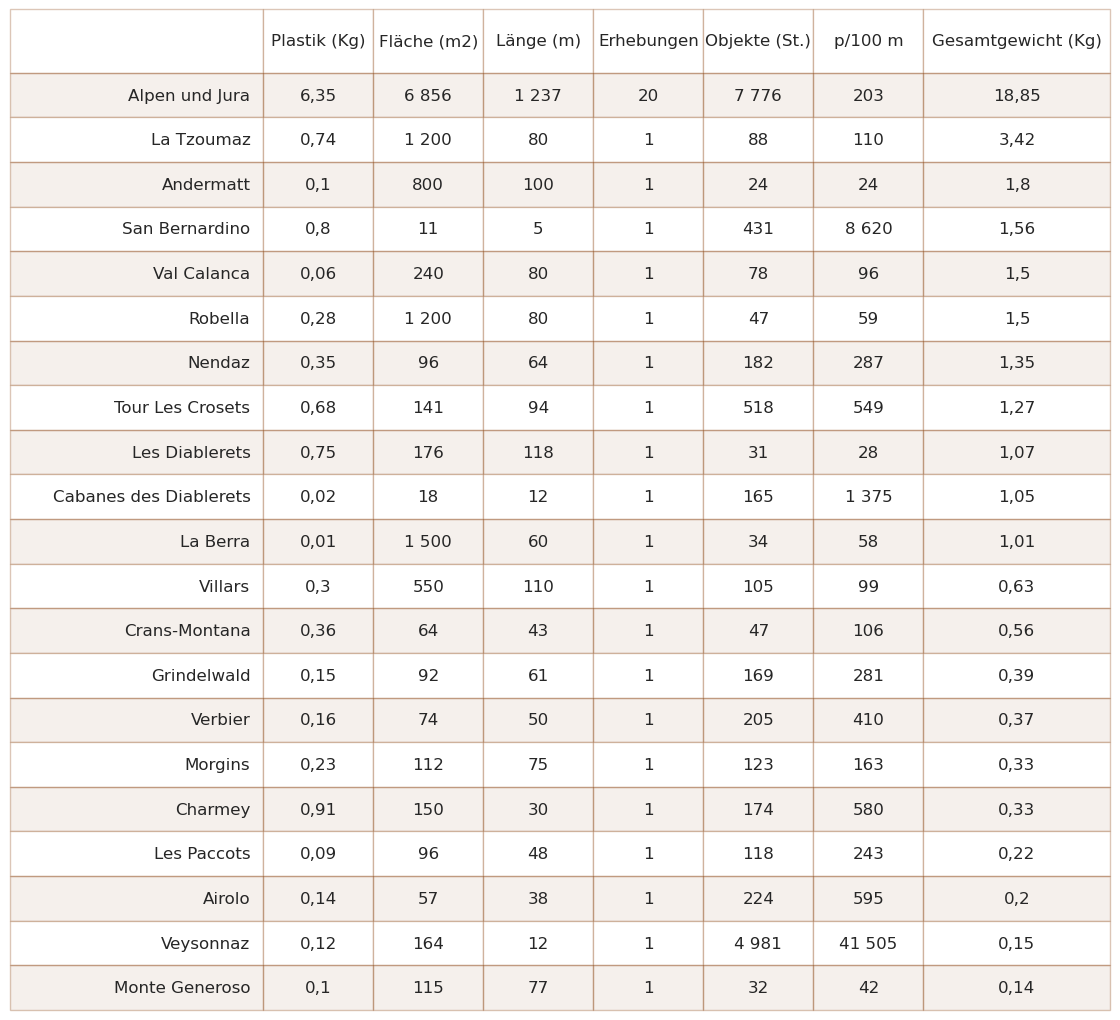

In [3]:
# the dimensional sumaries for each trash count
dims_table = admin_details.dimensionalSummary()

# for this report columns need to be added to standard dimensions
# adding the pcs per unit column, add the region total first
dims_table.loc["Alpen und Jura", unit_label] = fdx.sample_totals[unit_label].median()

for location in admin_details.locations_of_interest:
    index_name = proper_names[location]
    value = unit_label_map.loc[location, unit_label]
    dims_table.loc[index_name, unit_label] = value

# !surprise! the surveyors used the micro plastics weight in  field to log the sample total weights in grams
# the total weight field was used to log the event total (in kilos), map these to the dims table
# which means the total weight column needs to be dropped from this view
new_columns = list(dims_table.columns)
new_columns.remove("total_w")
dims_table = dims_table[new_columns]

# map the mic_plas_w column back to the dims table
weights_map = admin_details.dims_data[["location", "mic_plas_w"]].set_index("location")

# add the cumulative total
dims_table.loc["Alpen und Jura", "Gesamtgewicht (Kg)"] = round(weights_map.mic_plas_w.sum()/1000, 2)


for location in admin_details.locations_of_interest:
    index_name = proper_names[location]
    value = weights_map.loc[location, "mic_plas_w"]
    dims_table.loc[index_name, "Gesamtgewicht (Kg)"] = round(value/1000, 2)

# format the table for display
# convert the plastic totals from grams to kilos
dims_table.mac_plast_w = (dims_table.mac_plast_w/1000).round(2)
dims_table = dims_table.sort_values(by="Gesamtgewicht (Kg)", ascending=False)

# convert samples, area, length and unit_label to integers
# the thousands are separated by a space not a comma or decimal
as_type_int = ["samples", "quantity", unit_label, "area", "length"]
dims_table[as_type_int] = dims_table[as_type_int].astype(int)

# add a space to separate the thousands columns
dims_table[as_type_int] = dims_table[as_type_int].applymap(lambda x: featuredata.thousandsSeparator(int(x), "de"))

# the decimal is replaced by a comma
replace_decimal = ["mac_plast_w", "Gesamtgewicht (Kg)"]
dims_table[replace_decimal] = dims_table[replace_decimal].applymap(lambda x: featuredata.replaceDecimal(str(x)))

# rename the columns to german and reset the index
dims_table = dims_table.rename(columns=featuredata.dims_table_columns_de)
dims_table.reset_index(inplace=True, drop=False)

# make table
fig, ax = plt.subplots(figsize=(14.2, 13))
sut.hide_spines_ticks_grids(ax)
a_table = sut.make_a_table(ax,dims_table.values , colLabels=dims_table.columns, colWidths=[.23, *[.10]*6, .17], a_color=table_row)
a_table.get_celld()[(0,0)].get_text().set_text(" ")
a_table.set_fontsize(12)
glue('alpes_survey_area_dimensional_summary', fig, display=False)
plt.close()

```{glue:figure} alpes_survey_area_dimensional_summary
---
name: 'alpes_survey_area_dimensional_summary'
---
` `
```
{numref}`Abbildung %s: <alpes_survey_area_dimensional_summary>` Die aggregierten Ergebnisse der Abfallerhebungen. Ein Teil der Daten befindet sich aus Platzgründen in einer zweiten Tabelle darunter.

### Gesamtzahlen in Bezug auf die Clean-ups

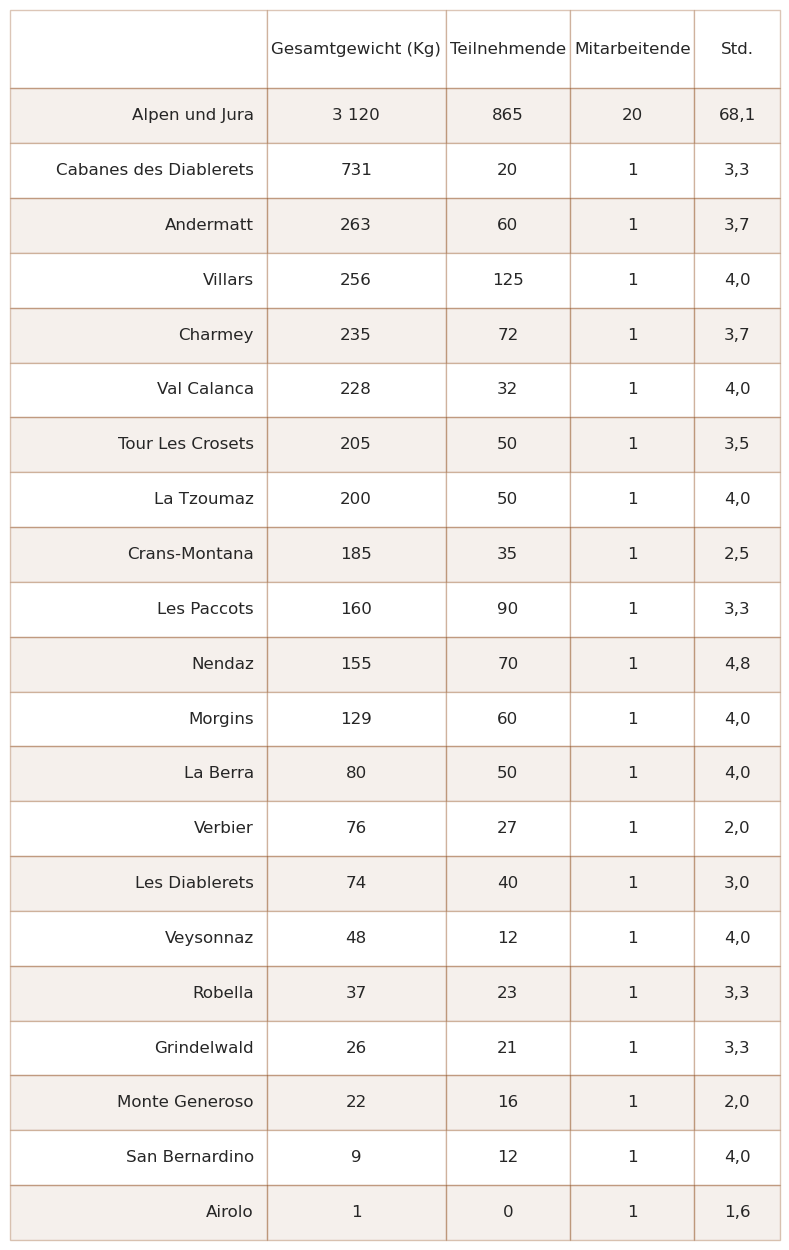

In [21]:
# the event totals include the amount collected but not counted
# the number of participants, the number of staff and the time to complete
# the event.
event_totals = admin_details.dims_data[["location", "total_w", "num_parts_other", "num_parts_staff", "time_minutes"]].copy()

# the names are changed to proper names and set as the index
event_totals["location"] = event_totals.location.map(lambda x: proper_names.loc[x])
event_totals.set_index("location", inplace=True)

# sum all the events to give the total for the feauture
event_totals.loc[this_feature["name"]] = event_totals.sum(numeric_only=True, axis=0)

# convert minutes to hours
event_totals.time_minutes = (event_totals.time_minutes/60).round(1)
event_totals = event_totals.sort_values(by="total_w", ascending=False)

# formatting for display
thousands = ["total_w", "num_parts_other"]
event_totals[thousands] = event_totals[thousands].applymap(lambda x: featuredata.thousandsSeparator(int(x), "de"))
event_totals["time_minutes"] = event_totals.time_minutes.map(lambda x: featuredata.replaceDecimal(str(x)))

new_column_names = {
    "total_w":  "Gesamtgewicht (Kg)",
    "num_parts_other": "Teilnehmende", 
    "num_parts_staff": "Mitarbeitende",
    "time_minutes": "Std."
}    

table_two = event_totals.rename(columns=new_column_names)
table_two.reset_index(inplace=True)

# make a table
fig, axs = plt.subplots(figsize=(8,len(table_two)*.6))
sut.hide_spines_ticks_grids(axs)

a_table = sut.make_a_table(axs, table_two.values, colLabels=table_two.columns, colWidths=[.33, .23, *[.16]*2, .11])
a_table.get_celld()[(0,0)].get_text().set_text(" ")
a_table.set_fontsize(12)

plt.tight_layout()
glue('alpes_survey_area_event_summaries', fig, display=False)
plt.close()

```{glue:figure} alpes_survey_area_event_summaries
---
name: 'alpes_survey_area_event_summaries'
---
` `
```

{numref}`Abbildung %s: <alpes_survey_area_event_summaries>` Die Gesamtmenge des gesammelten Mülls in Kilogramm, die Anzahl der Teilnehmenden und des Personals sowie die Zeit, die für die Durchführung der Erhebung benötigt wurde.

### Landnutzungsprofil der Erhebungsorte

Das Landnutzungsprofil zeigt, welche Nutzungen innerhalb eines Radius von 1500 m um jeden Erhebungsort dominieren. Flächen werden einer von den folgenden vier Kategorien zugewiesen:

* Fläche, die von Gebäuden eingenommen wird in %
* Fläche, die dem Wald vorbehalten ist in %
* Fläche, die für Aktivitäten im Freien genutzt wird in %
* Fläche, die von der Landwirtschaft genutzt wird in %

Strassen (inkl. Wege) werden als Gesamtzahl der Strassenkilometer innerhalb eines Radius von 1500 m angegeben.

Es wird zudem angegeben, wie viele Flüsse innerhalb eines Radius von 1500 m um den Erhebungsort herum in das Gewässer münden.

Das Verhältnis der gefundenen Abfallobjekte unterscheidet sich je nach Landnutzungsprofil. Das Verhältnis gibt daher einen Hinweis auf die ökologischen und wirtschaftlichen Bedingungen um den Erhebungsort.

Für weitere Informationen siehe *[17 Landnutzungsprofil](luseprofile)*

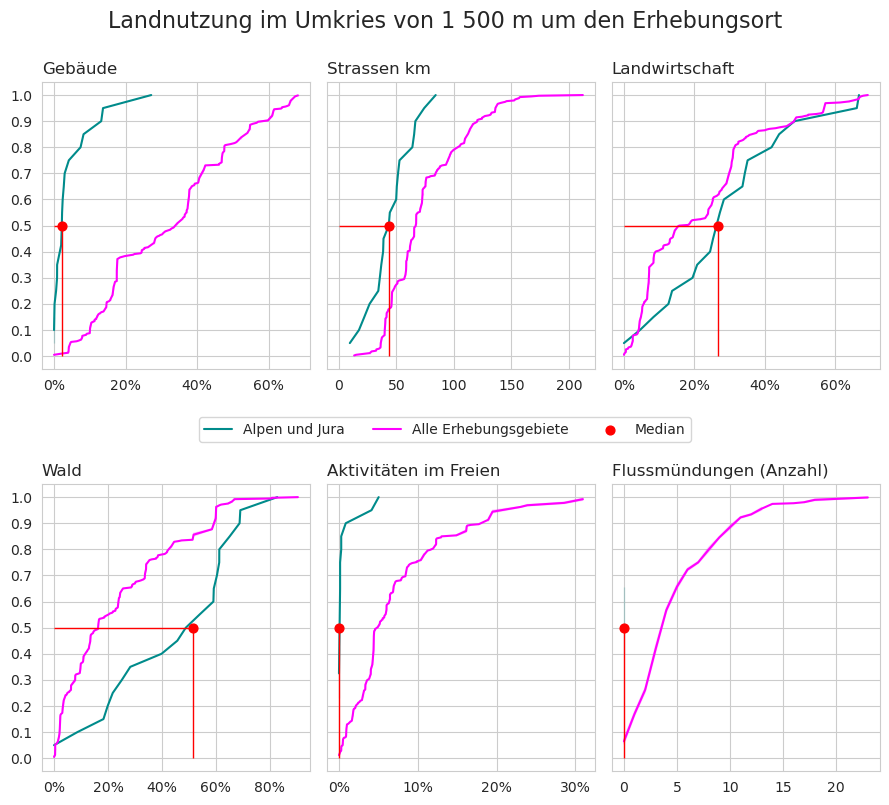

In [5]:
# this gets all the data for the project
land_use_kwargs = {
    "data": period_data.period_data,
    "index_column":"loc_date",
    "these_features": this_feature['slug'],
    "feature_level":this_feature['level']   
}

# the landuse profile of the project
project_profile = featuredata.LandUseProfile(**land_use_kwargs).byIndexColumn()

# update the kwargs for the feature data
land_use_kwargs.update({"data":fdx.feature_data})

# build the landuse profile of the feature
feature_profile = featuredata.LandUseProfile(**land_use_kwargs)

# this is the component features of the report
feature_landuse = feature_profile.featureOfInterest()

fig, axs = plt.subplots(2, 3, figsize=(9,8), sharey="row")

for i, n in enumerate(featuredata.default_land_use_columns):
    r = i%2
    c = i%3
    ax=axs[r,c]    
    # the value of land use feature n
    # for each element of the feature
    for element in feature_landuse:
        # the land use data for a feature
        data = element[n].values
        # the name of the element
        element_name = element[feature_profile.feature_level].unique()
        # proper name for chart
        label = featuredata.river_basin_de[element_name[0]]
        # cumulative distribution        
        xs, ys = featuredata.empiricalCDF(data)
        # the plot of landuse n for this element
        sns.lineplot(x=xs, y=ys, ax=ax, label=label, color=bassin_pallette[element_name[0]])
    
    # the value of the land use feature n for the project
    testx, testy = featuredata.empiricalCDF(project_profile[n].values)
    sns.lineplot(x=testx, y=testy, ax=ax, label=top, color="magenta")
    
    # get the median landuse for the feature
    the_median = np.median(data)
    
    # plot the median and drop horizontal and vertical lines
    ax.scatter([the_median], 0.5, color="red",s=40, linewidth=1, zorder=100, label="Median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color="red", linewidth=1)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color="red", linewidth=1)
    
    if i <= 3:
        if c == 0:            
            ax.yaxis.set_major_locator(MultipleLocator(.1))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, "%"))        
    else:
        pass      
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()    
    ax.set_title(featuredata.luse_de[n], loc='left')
    
plt.tight_layout()
plt.subplots_adjust(top=.91, hspace=.4)
plt.suptitle("Landnutzung im Umkries von 1 500 m um den Erhebungsort", ha="center", y=1, fontsize=16)
fig.legend(handles, labels, bbox_to_anchor=(.5,.5), loc="upper center", ncol=3) 

# capture the output
glue("alpes_survey_area_landuse", fig, display=False)

plt.close()

```{glue:figure} alpes_survey_area_landuse
---
name: 'alpes_survey_area_landuse'
---
` `
```

{numref}`Abbildung %s: <alpes_survey_area_landuse>` Die Erhebungsorte in den Alpen und im Jura wiesen im Vergleich zu den Ergebungsorten IQAASL einen höheren Prozentsatz an forst- und landwirtschaftlichen Flächen und einen geringeren Prozentsatz an bebauter Fläche (Gebäude) und an Fläche, die für Aktivitäten im Freien genutzt werden, auf.

Die aggregierten Ergebnisse zeigen den Unterschied zwischen den beiden Erhebungsmethoden. Die drei Erhebungsorte mit dem höchsten p/100 m haben auch die kürzeste Länge. Im Fall von Cabanes-des-Diablerets entspricht die Fläche (in m2) der Länge (in m), was darauf hindeutet, dass ein kleiner Bereich um eine Struktur oder ein Gebäude herum vermessen wurde. In Veysonnaz befindet sich die Talstation der Seilbahn nach Thyon (Wintersportgebiet Veysonnaz / 4 Vallées).

Der Unterschied in den Methoden führt zu abweichenden Ergebnissen. Ausserdem wurden diese beiden Orte aufgrund der früheren Erfahrungen der Person, die die Erhebung ausführt, speziell für die Bestandsaufnahme ausgewählt. Wegen der unterschiedlichen Dimensionen und Methoden werden die Erhebungsergebnisse aus Veysonnaz, San-Beranardino und Cabanes-des-Diablerets in der weiteren Analyse nicht berücksichtigt.

## Verteilung der Erhebungsergebnisse¶

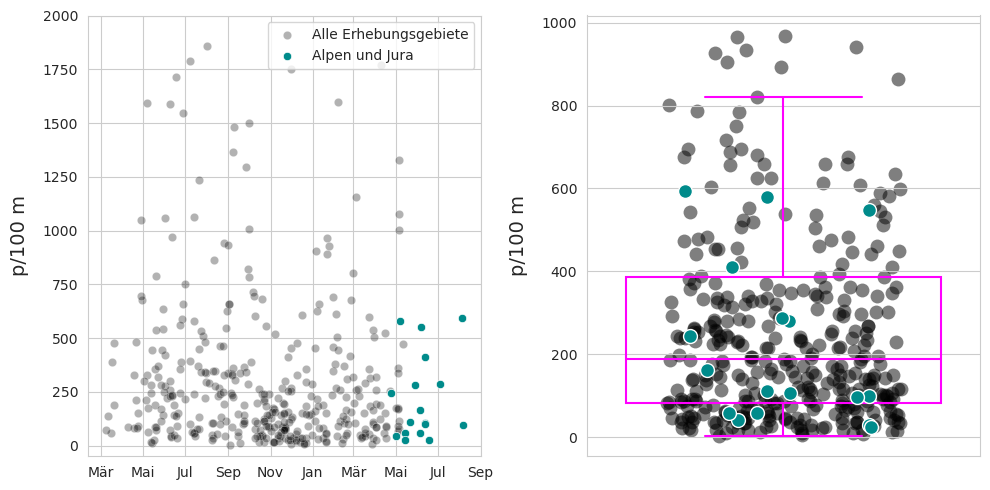

In [6]:
dx = period_data.parentSampleTotals(parent=False)

not_trail_samples = ["veysonnaz", "cabanes-des-diablerets", "san-bernardino"]

fdt = fd[~fd.location.isin(not_trail_samples)].copy()
fdt_samples = fdx.sample_totals[~fdx.sample_totals.location.isin(not_trail_samples)].copy()

material_map = fdx.mMap
description_map = fdx.dMap

fig, axs = plt.subplots(1,2, figsize=(10,5))

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

ax = axs[0]
ax.set_ylim(-50, 2000)

# the cumlative distributions:
axtwo = axs[1]

# feature surveys
sns.scatterplot(data=dx, x="date", y=unit_label, label=top, color="black", alpha=0.3,  ax=ax)
# all other surveys
sns.scatterplot(data=fdt_samples, x="date", y=unit_label, label=this_feature["name"], color=bassin_pallette[this_feature["slug"]], edgecolor="white", ax=ax)

ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.set_ylim(-50, 2000)

axtwo = axs[1]

box_props = {
    "boxprops":{"facecolor":"none", "edgecolor":"magenta"},
    "medianprops":{"color":"magenta"},
    "whiskerprops":{"color":"magenta"},
    "capprops":{"color":"magenta"}
}
sns.boxplot(data=dx, y=unit_label, color="black",  ax=axtwo, showfliers=False, **box_props, zorder=1)
sns.stripplot(data=dx[dx[unit_label] <= 1000], s=10, y=unit_label, color="black", ax=axtwo, alpha=0.5, jitter=0.3, zorder=0)
sns.stripplot(data=fdt_samples[fdt_samples[unit_label] <= 1000], y=unit_label, color=bassin_pallette[this_feature["slug"]], s=10, edgecolor="white",linewidth=1, ax=axtwo, jitter=0.3, zorder=2)

axtwo.set_xlabel("")
axtwo.set_ylabel(unit_label, **ck.xlab_k14)

axtwo.tick_params(which="both", axis="x", bottom=False)
ax.legend()

plt.tight_layout()

glue('alpes_survey_area_sample_totals', fig, display=False)
plt.close()

```{glue:figure} alpes_survey_area_sample_totals
---
name: 'alpes_survey_area_sample_totals'
---
` `
```

{numref}`Abbildung %s: <alpes_survey_area_sample_totals>` __Links__: Zusammenfassung der Daten aller Erhebungen Erhebungsgebiet Alpes März 2020 bis September 2021, n = 20. __Rechts:__ Gefundene Materialarten im Erhebungsgebiet Alpes in Stückzahlen und als prozentuale Anteile (stückzahlbezogen).

### Zusammenfassende Daten und Materialtypen

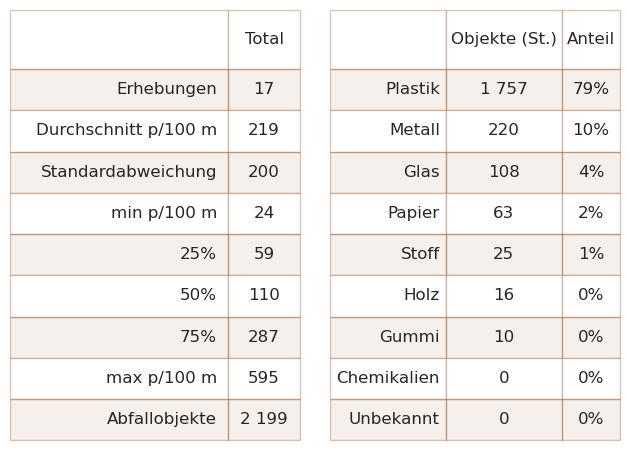

In [7]:
def columnsAndOperations(column_operations: list = None, columns: list = None, unit_label: str = None):
    if column_operations is None:
        column_operation = {unit_label: "median", "quantity": "sum"}
    else:
        column_operation = {x[0]: x[1] for x in column_operations}
    if columns is None:
        columns = ["loc_date", "groupname"]
    
    return columns, column_operation

def changeSeriesIndexLabels(a_series: pd.Series = None, change_names: {} = None):
    """A convenience function to change the index labels of a series x.
    Change_names is keyed to the series index.

    :param a_series: A pandas series
    :param change_names: A dictionary that has keys = x.index and values = new x.index label
    :return: The series with the new labels
    """
    
    new_dict = {}
    for param in a_series.index:
        new_dict.update({change_names[param]: a_series[param]})
    return pd.Series(new_dict)

def createSummaryTableIndex(unit_label, language="en"):
    """Assigns the current units to the keys and creates
    custom key values based on language selection.

    :param unit_label: The current value of unit label
    :param language: the two letter abbreviation for the current language
    :return: the pd.describe dict with custom labels
    """
    
    if language == "en":
        new_data = {"count": "# samples",
                    "mean": f"average {unit_label}",
                    "std": "standard deviation",
                    "min": f"min {unit_label}",
                    "max": f"max {unit_label}",
                    "25%": "25%",
                    "50%": "50%",
                    "75%": "75%",
                    "total objects": "total objects",
                    "# locations": "# locations",
                    }
    elif language == "de":
        new_data = {"count": "Erhebungen",
                    "mean": f"Durchschnitt {unit_label}",
                    "std": "Standardabweichung",
                    "min": f"min {unit_label}",
                    "max": f"max {unit_label}",
                    "25%": "25%",
                    "50%": "50%",
                    "75%": "75%",
                    "total objects": "Abfallobjekte",
                    "# locations": "Anzahl der Standorte",
                    }
    else:
        print(f"ERROR {language} is not an option")
        new_data = {}
    
    return new_data

def makeDailyTotalSummary(
    sample_totals: pd.DataFrame = None, unit_label: str = None, language: str = None):

    # the summary of the dependent variable
    a = sample_totals[unit_label].describe().round(2)
    a["total objects"] = sample_totals.quantity.sum()

    # assign appropriate language to index names
    # retrieve the appropriate index names based on language
    table_index = createSummaryTableIndex(unit_label, language=language)

    # assign the new index
    summary_table = changeSeriesIndexLabels(a, table_index)

    return summary_table

def codeSummary(
    feature_data: pd.DataFrame = None, unit_label: str = None, column_operations=None,
    material_map: pd.DataFrame = None, description_map: pd.DataFrame = None):

        
    if column_operations is None:
        column_operations = {
            "column_operations": [(unit_label, "median"), ("quantity", "sum")],
            "columns": ["code"],
            "unit_label": unit_label
        }

    columns, column_operation = columnsAndOperations(**column_operations)

    # apply the column operations
    code_totals = feature_data.groupby(columns, as_index=False).agg(column_operation)
    # percent of total
    code_totals["% of total"] = ((code_totals.quantity / code_totals.quantity.sum()) * 100).round(2)
    # fail and fail-rate
    code_totals["fail"] = code_totals.code.map(lambda x: feature_data[
        (feature_data.code == x) & (feature_data.quantity > 0)].loc_date.nunique())
    
    code_totals["fail rate"] = ((code_totals.fail / feature_data.loc_date.nunique()) * 100).astype("int")

    # the code data comes from the feature data (survey results)
    # Add the description of the code and the material
    code_totals.set_index(columns, inplace=True)
    code_totals["item"] = code_totals.index.map(lambda x: description_map[x])
    code_totals["material"] = code_totals.index.map(lambda x: material_map[x])

    code_totals = code_totals[["item", "quantity", "% of total", unit_label, "fail rate", "material"]]

    return code_totals

def materialSummary(code_summary: pd.DataFrame = None):  
      

    a = code_summary.groupby("material", as_index=False).quantity.sum()
    a["% of total"] = a['quantity'] / a['quantity'].sum()
    b = a.sort_values(by="quantity", ascending=False)
    
    return b

def mostCommon(code_summary: pd.DataFrame = None, fail_rate: int = None, limit: int = 10):

    # the top ten by quantity
    most_abundant = code_summary.sort_values(by="quantity", ascending=False)[:limit]
    # the most common
    most_common = code_summary[code_summary["fail rate"] >= fail_rate].sort_values(by="quantity", ascending=False)
    # merge with most_common and drop duplicates
    # it is possible (likely) that a code will be abundant and common
    m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

    return m_common
        


s_table_kwargs = {
    "sample_totals": fdt_samples,
    "unit_label": unit_label,
    "language": language
}

code_summary_kwargs = {
    "feature_data": fdt,
    "unit_label": unit_label,
    "column_operations": None,
    "description_map": description_map,
    "material_map": material_map
}


code_summary = codeSummary(**code_summary_kwargs)
cs = makeDailyTotalSummary(**s_table_kwargs)

combined_summary =[(x, featuredata.thousandsSeparator(int(cs[x]), language)) for x in cs.index]


# the materials table
fd_mat_totals = materialSummary(code_summary=code_summary)
fd_mat_totals = featuredata.fmtPctOfTotal(fd_mat_totals, around=0)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Objekte (St.)", "% of total":"Anteil"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values
fd_mat_t = [(x[0], featuredata.thousandsSeparator(int(x[1]), language), x[2]) for x in fd_mat_t]

# make tables
fig, axs = plt.subplots(1,2)

# names for the table columns
a_col = [this_feature["name"], "Total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.75,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")
table_two.set_fontsize(12)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .4,.2],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")
table_three.set_fontsize(12)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
glue('alpes_survey_area_sample_material_tables', fig, display=False)
plt.close()

```{glue:figure} alpes_survey_area_sample_material_tables
---
name: 'alpes_survey_area_sample_material_tables'
---
` `
```

{numref}`Abbildung %s: <alpes_survey_area_sample_material_tables>` __Links:__ Zusammenfassung der erhebungen entlang der Wanderwege. __Rechts:__ Aufschlüsselung nach Materialart (Stückzahlen und prozentuale Verteilung).

## Die am häufigsten gefundenen Objekte

Die am häufigsten gefundenen Objekte sind die zehn mengenmässig am meisten vorkommenden Objekte und/oder Objekte, die in mindestens 50 % aller Erhebungen identifiziert wurden (Häufigkeitsrate).

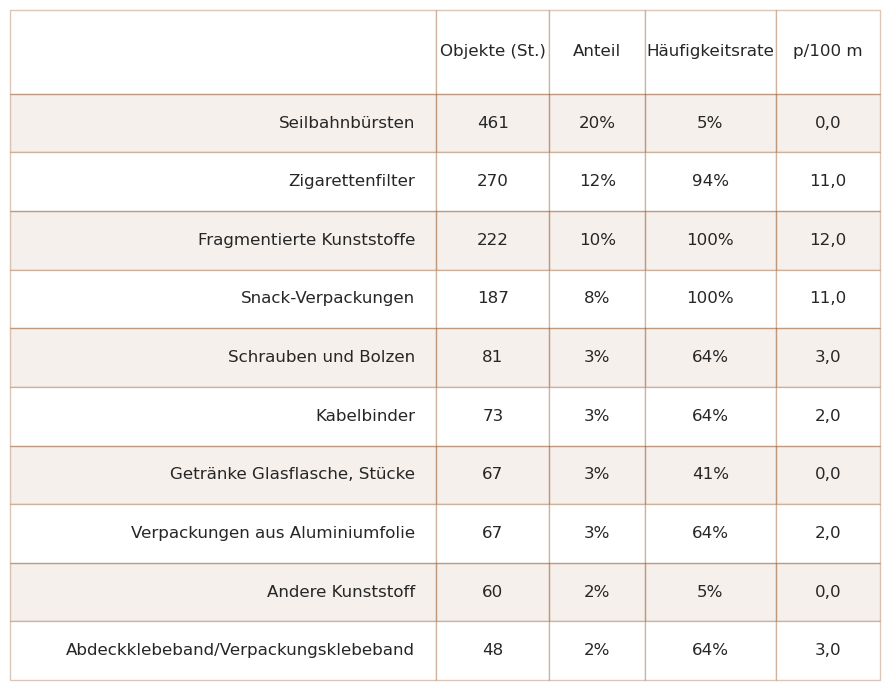

In [8]:
mcc = mostCommon(code_summary=code_summary, fail_rate=fail_rate)
mcc["item"] = mcc.index.map(lambda x: description_map.loc[x])

# make a copy for string formatting
most_common = mcc.copy()

# format values for table
most_common["% of total"] = most_common["% of total"].map(lambda x: F"{int(x)}%")
most_common["quantity"] = most_common.quantity.map(lambda x:featuredata.thousandsSeparator(x, language))
most_common["fail rate"] = most_common["fail rate"].map(lambda x: F"{x}%")
most_common[unit_label] = most_common[unit_label].map(lambda x: featuredata.replaceDecimal(round(x,1)))

# format the table headers
cols_to_use = featuredata.most_common_objects_table_de
cols_to_use.update({unit_label:unit_label})
table_data = most_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(9,len(most_common)*.7))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, table_data,  colLabels=list(cols_to_use.values()), colWidths=[.49, .13,.11,.15, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")
table_four.set_fontsize(12)
plt.tight_layout()
glue('alpes_survey_area_most_common_tables', fig, display=False)
plt.close()

```{glue:figure} alpes_survey_area_most_common_tables
---
name: 'alpes_survey_area_most_common_tables'
---
` `
```

{numref}`Abbildung %s: <alpes_survey_area_most_common_tables>` Häufigste Objekte auf Wanderwegen: Objekte mit einer Häufigkeitsrate von mindestens 50 % und/oder die 10 häufigsten Objekte. Zusammengenommen stellen die zehn häufigsten Objekte 69 % aller gefundenen Objekte dar. p/100 m: Medianwert der Erhebung.

### Die am häufigsten gefundenen Gegenstände nach Erhebungsort   

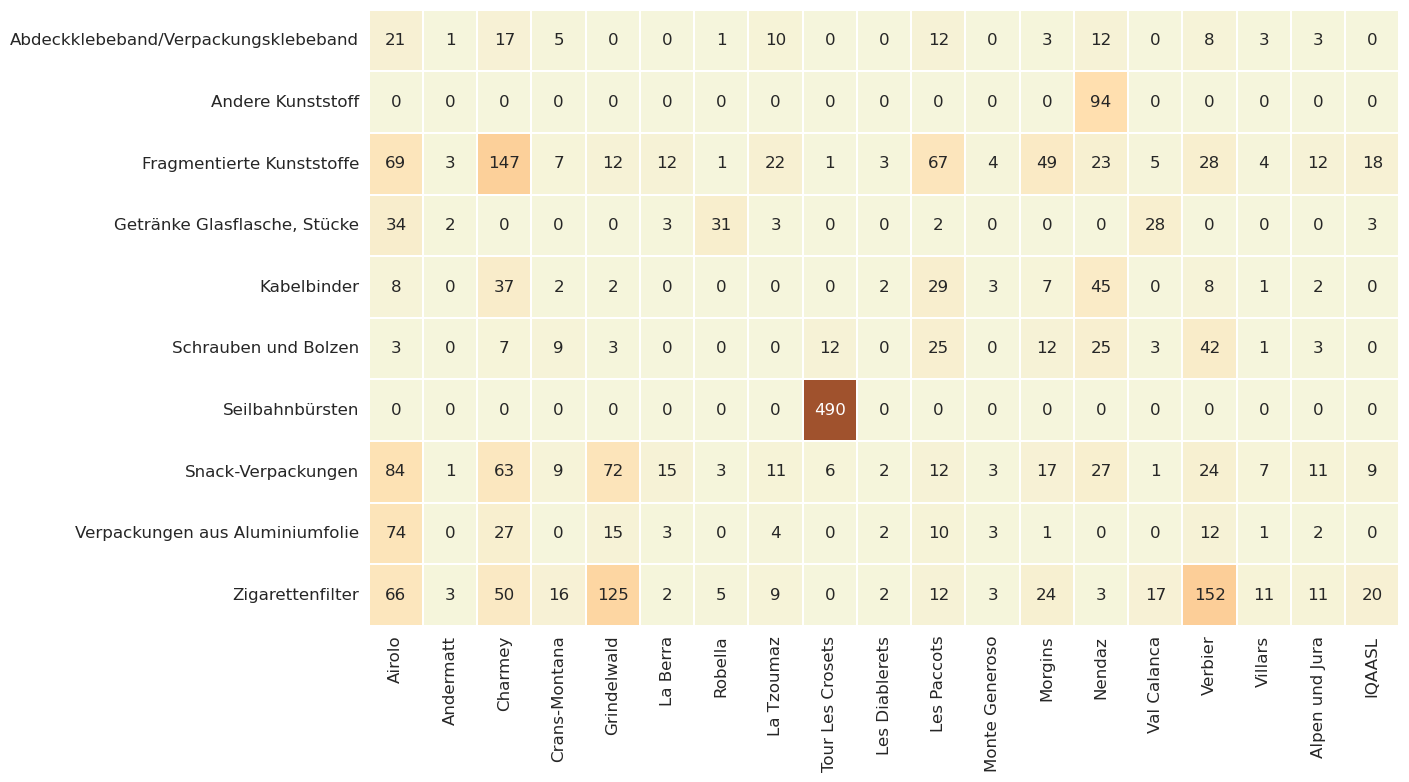

In [9]:
def componentMostCommonPcsM(
    feature_data: pd.DataFrame = None, most_common: pd.DataFrame = None, columns: list = None, unit_label: str = None,
    feature_component: str = None, column_operations: list = None, description_map: pd.DataFrame = None):

    codes = most_common.index
    
    if column_operations is None:        
        column_operations = {
            "column_operations":  [(unit_label, "sum"), ("quantity", "sum")],
            "columns":  [feature_component, "loc_date", "code"],
            "unit_label": unit_label
        }

    columns, column_operation = columnsAndOperations(**column_operations)

    mask = feature_data.code.isin(codes)    

    a = feature_data[mask].groupby(columns, as_index=False).agg(column_operation)
    a = a.groupby([feature_component, "code"], as_index=False)[unit_label].median()

    # map the description to the code
    a["item"] = a.code.map(lambda x: description_map.loc[x])

    return a

       
def parentMostCommon(parent_data: pd.DataFrame = None, most_common: list = None, unit_label: str = None, 
                     percent: bool = False, name: str = None):
    
    data = parent_data[parent_data.code.isin(most_common)]   

    if percent:
        data = data.groupby('code', as_index=False).quantity.sum()
        data.set_index('code', inplace=True)
        data[name] = (data.quantity / data.quantity.sum()).round(2)

        return data[name]

    else:
        data = data.groupby(["loc_date", 'code'], as_index=False)[unit_label].sum()
        data = data.groupby('code', as_index=False)[unit_label].median()
        data.set_index('code', inplace=True)
        data[name] = data[unit_label]

        return data[name]
    
aggregate_kwargs = {
    "parent_data": period_data.period_data,
    "most_common": mcc.index,
    "unit_label": unit_label,
    "percent": False,
    "name":"IQAASL",
}        

    
component_kwargs = {
    "feature_data": fdt,
    "most_common": most_common,
    "feature_component": fdx.feature_component,
    "unit_label": unit_label,
    "description_map": description_map,
}

    
# the columns needed to build the heat map
heat_map_columns = ["item", "location", unit_label]

# the results for the most common codes at the component level
components = componentMostCommonPcsM(**component_kwargs)

# pivot that to make a heat map layouy
mc_comp = components[heat_map_columns].pivot(columns='location', index='item')

# drop any indexing above the component name
mc_comp.columns = mc_comp.columns.get_level_values(1)
mc_comp.rename(columns={x:proper_names[x] for x in mc_comp.columns}, inplace=True)

# switch the index to the item description
mc_feature = mcc[["item", unit_label]].set_index("item")

# add a column for the results of all the feature data
mc_comp[this_feature["name"]] = mc_feature

# get the resluts of the feature most common from IQAASL results
iqaasl_results = parentMostCommon(**aggregate_kwargs)

# replace the code with a description
new_labels = {x : description_map[x] for x in iqaasl_results.index}
mc_iqaasl = featuredata.changeSeriesIndexLabels(a_series=iqaasl_results, change_names=new_labels)

# add a column for the results of all the IQAASL data
mc_comp["IQAASL"] = mc_iqaasl

# chart that
fig, ax  = plt.subplots(figsize=(len(mc_comp.columns)*.7,len(mc_comp)*.8))

sns.heatmap(mc_comp, ax=ax, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0f", cbar=False, linewidth=.1, linecolor="white")
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=12, which="both", axis="both")

plt.setp(ax.get_xticklabels(), rotation=90)

glue('alpes_survey_area_most_common_heat_map', fig, display=False)
plt.close()

```{glue:figure} alpes_survey_area_most_common_heat_map
---
name: 'alpes_survey_area_most_common_heat_map'
---
` `
```

{numref}`Abbildung %s: <alpes_survey_area_most_common_heat_map>` Häufigste Objekte an Wanderwegen: Median p/100 m.

### Seilbahnbürsten

```{figure} resources/images/alpes_valaisanne/veysonnaz_brosse.jpg
---
name: alpes_survey_area_teleski_brush
---
` `
```
{numref}`Abbildung %s: <alpes_survey_area_teleski_brush>` Seilbahnbürsten, die verwendet werden, um Eis und Schnee von Skiliften zu entfernen, können sich von der Anlage lösen und Tausende von schweren Kunststofffäden erzeugen.

## Verwendungszweck der gefundenen Objekte

Der Verwendungszweck basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert.

* Abwasser: Objekte, die aus Kläranlagen freigesetzt werden, sprich Objekte, die wahrscheinlich über die Toilette entsorgt werden
* Mikroplastik (< 5 mm): fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion
* Infrastruktur: Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung
* Essen und Trinken: alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen
* Landwirtschaft: Materialien z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw.
* Tabakwaren: hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien
* Freizeit und Erholung: Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw.
* Verpackungen ausser Lebensmittel und Tabak: Verpackungsmaterial, das nicht lebensmittel- oder tabakbezogen ist
* Plastikfragmente: Plastikteile unbestimmter Herkunft oder Verwendung
* Persönliche Gegenstände: Accessoires, Hygieneartikel und Kleidung

Im Anhang (Kapitel 3.6.3) befindet sich die vollständige Liste der identifizierten Objekte, einschliesslich Beschreibungen und Gruppenklassifizierung. Das Kapitel [16 Codegruppen](codegroups) beschreibt jede Codegruppe im Detail und bietet eine umfassende Liste aller Objekte in einer Gruppe.

*__Unten:__ Wanderwege Nutzen der gefundenen Objekte: % der Gesamtzahl nach Wassermerkmal. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, bleiben nach Grösse klassifiziert.*  

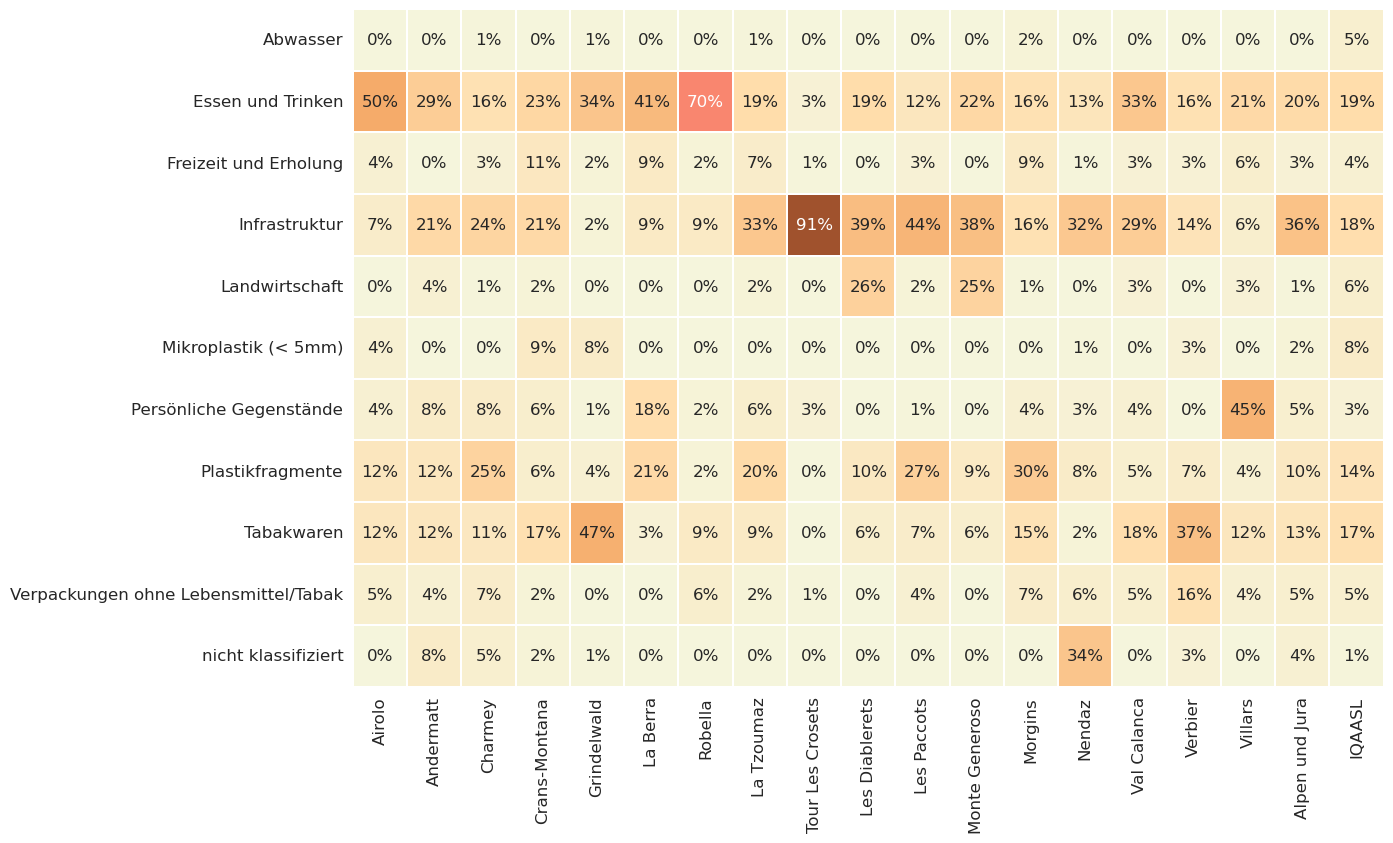

In [10]:
def parentGroupTotals(data: pd.DataFrame = None, most_common: list = None, unit_label: str = None, 
                     percent: bool = False, name: str = None):
    
    if percent:
        data = data.groupby('groupname', as_index=False).quantity.sum()
        data.set_index('groupname', inplace=True)
        data[name] = (data.quantity / data.quantity.sum()).round(2)

        return data[name]

    else:
        data = data.groupby(["loc_date", 'groupname'], as_index=False)[unit_label].sum()
        data = data.groupby('groupname', as_index=False)[unit_label].median()
        data.set_index('groupname', inplace=True)
        data[name] = data[unit_label]

        return data[name]
    
aggregate_kwargs = {
    "data": period_data.period_data,
    "unit_label": unit_label,
    "percent": True,
    "name":"IQAASL",
}        

    
component_kwargs = {
    "data":fdt,    
    "unit_label": unit_label,
    "name": this_feature["name"],
    "percent": True
    
}
 



d = fdx.componentCodeGroupResults()
# pivot that
pt_comp = d[~d.location.isin(not_trail_samples)][["location", "groupname", '% of total' ]].pivot(columns="location", index="groupname")

# quash the hierarchal column index
pt_comp.columns = pt_comp.columns.get_level_values(1)
pt_comp.rename(columns = {x:proper_names[x] for x in pt_comp.columns}, inplace=True)
pt_comp[this_feature["name"]] = parentGroupTotals(**component_kwargs)
pt_comp["IQAASL"] = parentGroupTotals(**aggregate_kwargs) 


# make figure
fig, ax = plt.subplots(figsize=(len(pt_comp.columns)*.7,len(pt_comp)*.8))

sns.heatmap(pt_comp , ax=ax, cmap=cmap2, annot=True,  annot_kws={"fontsize":12}, fmt=".0%", cbar=False, linewidth=.1, linecolor="white")

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=12, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.setp(ax.get_yticklabels(), rotation=0)

glue('alpes_survey_area_codegroup_percent', fig, display=False)

plt.close()

```{glue:figure} alpes_survey_area_codegroup_percent
---
name: 'alpes_survey_area_codegroup_percent'
---
` `
```
{numref}`Abbildung %s: <alpes_survey_area_codegroup_percent>` Verwendungszweck der gefundenen Objekte an Wanderwegen: prozentualer Anteil an der Gesamtzahl nach Verwendungszweck. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, bleiben nach Grösse klassifiziert.

{numref}`Abbildung %s: <alpes_survey_area_codegroup_pcsm>` *__Unten:__ Verwendungszweck der gefundenen Objekte an Wanderwegen: Median p/100 m.*

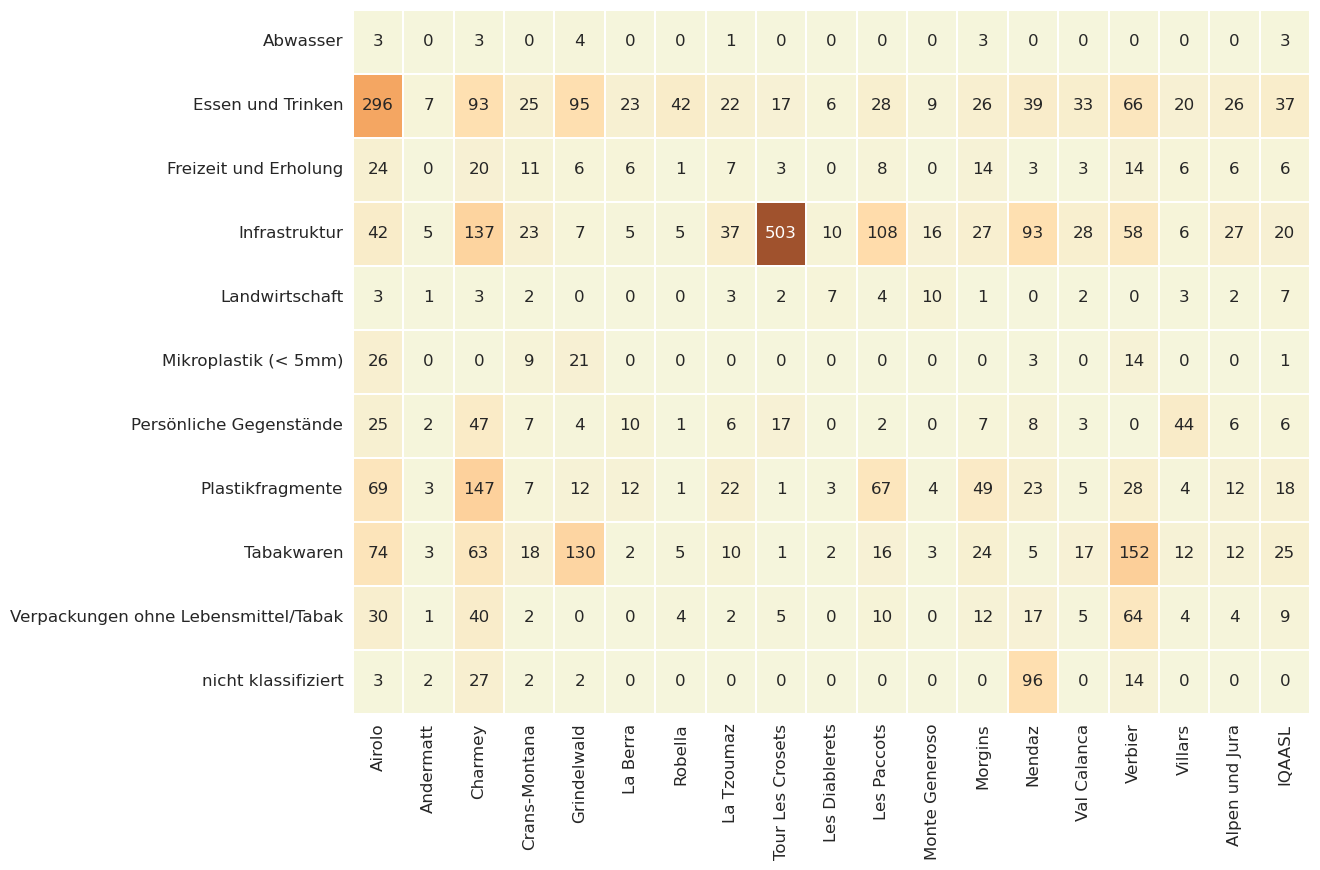

In [11]:
aggregate_kwargs = {
    "data": period_data.period_data,
    "unit_label": unit_label,
    "percent": False,
    "name":"IQAASL",
}        

    
component_kwargs = {
    "data":fdt,    
    "unit_label": unit_label,
    "name": this_feature["name"],
    "percent": False
    
}


pt_comp =  d[~d.location.isin(not_trail_samples)][["location", "groupname", unit_label]].pivot(columns="location", index="groupname")

# quash the hierarchal column index
pt_comp.columns = pt_comp.columns.get_level_values(1)
pt_comp.rename(columns = {x:proper_names[x] for x in pt_comp.columns}, inplace=True)
pt_comp[this_feature["name"]] = parentGroupTotals(**component_kwargs)
pt_comp["IQAASL"] = parentGroupTotals(**aggregate_kwargs) 

# make figure
fig, ax = plt.subplots(figsize=(len(pt_comp.columns)*.7,len(pt_comp)*.8))

sns.heatmap(pt_comp, ax=ax, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0f", cbar=False, linewidth=.1, linecolor="white")

ax.set_ylabel("")
ax.set_xlabel("")
ax.tick_params(labelsize=12, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.setp(ax.get_yticklabels(), rotation=0)
plt.tight_layout()

glue("alpes_survey_area_codegroup_pcsm", fig, display=False)

plt.close()

```{glue:figure} alpes_survey_area_codegroup_pcsm
---
name: 'alpes_survey_area_codegroup_pcsm'
---
` `
```

### Perzentil-Rangfolge der Erhebungsergebnisse in Bezug auf die Landnutzung

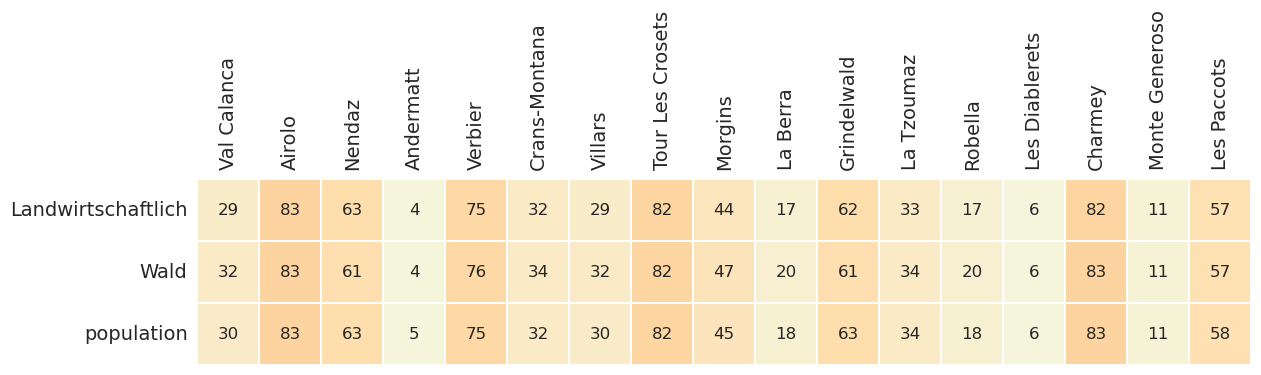

In [12]:
nvsn = fdt.location.unique()

l_f = ["% agg", "% woods", "population"]

this_range = (fdt[l_f[0]].min(), fdt[l_f[0]].max())
this_range_w = (fdt[l_f[1]].min(), fdt[l_f[1]].max())
this_range_p = (fdt[l_f[2]].min(), fdt[l_f[2]].max())

a_data = period_data.period_data.copy()

# apply them to all the data
# one test for agg -- a dominant land use feature of the sample data
some_data = a_data[(a_data[l_f[0]] >= this_range[0])&(a_data[l_f[0]] <= this_range[1])].copy()

# one test for woods -- the dominant land use feature of the sample data
some_data_w = a_data[(a_data[l_f[1]] >= this_range_w[0])&(a_data[l_f[1]] <= this_range_w[1])].copy()

# one test for population -- 
some_data_p = a_data[(a_data[l_f[2]] >= this_range_p[0])&(a_data[l_f[2]] <= this_range_p[1])].copy()

# remove Alps valaisannes
some_data = some_data[~some_data.location.isin(fd.location.unique())].copy()
some_data_w = some_data_w[~some_data_w.location.isin(fd.location.unique())].copy()
some_data_p = some_data_p[~some_data_p.location.isin(fd.location.unique())].copy()

# the number of samples and locations that have similar land use profiles as AV:
# agg to loc_date for each criteria
# data for charting and comparing
data=some_data.groupby(["loc_date","location",l_f[0]], as_index=False)[unit_label].sum()
data_w =some_data_w.groupby(["loc_date","location",l_f[1]], as_index=False)[unit_label].sum()
data_p = some_data_p.groupby(["loc_date","location",*l_f[1:]], as_index=False)[unit_label].sum()

# get the percentile ranking for each location under each condtion:
table_data = {}
for i,x in enumerate(nvsn):
    this_num = fdt_samples.loc[fdt_samples.location == x, unit_label].values[0]
    a = (stats.percentileofscore(data[unit_label].to_numpy(), this_num))
    b = (stats.percentileofscore(data_p[unit_label].to_numpy(), this_num))
    c = (stats.percentileofscore(data_w[unit_label].to_numpy(), this_num))
    table_data.update({x:{"Landwirtschaftlich":a, "Wald":b, "population":c}})

# make df and format
t_data = pd.DataFrame(table_data)
t_data = t_data.astype("int")
t_data.reset_index(inplace=True)
t_data.rename(columns={"index":"variable"}, inplace=True)
t_data.set_index("variable", inplace=True, drop=True)
t_data.rename(columns={x:proper_names.loc[x] for x in t_data.columns}, inplace=True)

fig, ax = plt.subplots(figsize=(len(nvsn)*.8,5))

axone = ax
sns.heatmap(t_data , ax=axone, cmap=cmap2, vmax=300, annot=True, annot_kws={"fontsize":12}, fmt="g", cbar=False, linewidth=.1, square=True, linecolor="white")

axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=True, labelbottom=False)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

glue('alpes_survey_area_pranking_luse', fig, display=False)

plt.close()

```{glue:figure} alpes_survey_area_pranking_luse
---
name: 'alpes_survey_area_pranking_luse'
---
` `
```
{numref}`Abbildung %s: <alpes_survey_area_pranking_luse>` Die Rangfolge der Erhebungsorte in den Alpen und im Jura in Bezug auf die Landnutzung. Die Erhebungsergebnisse in Airolo waren zum Beispiel höher als 83 % aller Erhebungen (Seen, Fliessgewässer, Alpen und Jura). In Andermatt liegen die Erhebungsergebnisse unter 95 % aller Erhebungen mit einem vergleichbaren Landnutzungsprofil.

## Diskussion

### Vergleich der Ergebnisse: Alpen und Jura versus Seen und Fliessgewässer

Der Medianwert beträgt 110 p/100 m für die 17 Erhebungsorte, die die Kriterien für Länge und Breite im Erhebungsgebiet Alpen und Jura erfüllen, und liegt damit unter dem Medianwert aller anderen Erhebungsgebiete (189 p/100 m). Objekte, die mit dem Konsum von Nahrungsmitteln, Getränken und Tabakwaren in Verbindung stehen, machten einen geringeren Prozentsatz der Gesamtzahl aus und wiesen eine niedrigere p/100 m-Rate auf als Erhebungsorte entlang von Wassersystemen. Dieser Unterschied könnte zum Teil auf die geringe Verstädterung zurückzuführen sein, die das Erhebungsgebiet Alpen und Jura im Vergleich zu allen anderen Erhebungsgebieten kennzeichnet.

Der Anteil von Objekten, die mit der Infrastruktur zusammenhängen, ist mit 36 % doppelt so hoch wie in allen Untersuchungsgebieten zusammen. Dies ist grösstenteils auf die Fäden von Seilbahnbürsten zurückzuführen, die in Les-Crosets in grossen Mengen gefunden wurden. Seilbahnbürsten werden verwendet, um den Schnee von der Oberseite der abgedeckten Seilbahnkabinen zu entfernen, wenn diese sich dem Einstiegsort nähern. Ähnlich wie Industriepellets oder Schaumstoffkügelchen in der aquatischen Umwelt werden Teile von Seilbahnbürsten wahrscheinlich immer wieder in gelegentlich grossen Mengen an ganz bestimmten Orten gefunden.

Das Verhältnis von Objekten, die mit der Infrastruktur zusammenhängen zu solchen, die mit dem Konsum von Lebensmitteln und Tabakwaren in Verbindung stehen, ist fast 1:1. Solche Ergebnisse sind typisch für Umgebungen mit einer besser entwickelten Infrastruktur, siehe  [Gemeinsame Verantwortung] (Verkehr). Fragmentierte Kunststoffe werden in ähnlichem Umfang wie in den anderen Untersuchungsgebieten gefunden. Neu auf der Liste der häufigsten Objekte sind Kabelbinder und Abdeckband. Beide Objekte werden auch an Seen und Fliessgewässern gefunden, allerdings mit einer Häufigkeit von unter 50 %.

Es sei daran erinnert, dass diese Erhebungen entlang von Wintersportinfrastrukturen (Pisten, Wartebereiche bei den Liften etc.) oder eines Wanderweges in einem Skigebiet durchgeführt wurden. Auch wenn die Nutzung im Winter erhöht sein mag, sind viele Gebiete auch im Sommer hervorragende Wandergebiete, so dass eine ganzjährige Nutzung dieser Regionen möglich ist.

#### Die am häufigsten gefundenen Objekte

Die am häufigsten vorkommenden Objekte machen 74 % sämtlicher gefundener Objekte aus. Die Zigarettenstummel lagen im Erhebungsgebiet Alpen und Jura nicht über dem nationalen Median, allerdings wurden in Verbier, Grindelwald und Airolo signifikante Werte festgestellt. Zudem sind spezifische Objekte aus der Gruppe der Infrastruktur vertreten, wie z. B.:   

1. Schrauben und Bolzen 
2. Kabelbinder
3. Abdeckband
4. Seilbahnbürste 

Das Fehlen von expandiertem oder extrudiertem Polystyrol in der Liste der am häufigsten vorkommenden Objekte im Erhebungsgebiet Alpen und Jura steht in scharfem Kontrast zu den anderen Erhebungsgebieten, in denen expandiertes oder extrudiertes Polystyrol etwa 13 % der Gesamtmenge ausmacht, siehe [_Seen und Flüsse_](allsurveysde).

### Implementierung von Abfallerhebungen in das bestehende Geschäftsmodell

Im Vergleich zu einer Abfallerhebung an Seen und Fliessgewässern deckt eine Aufräumaktion ein relativ grosses geographisches Gebiet ab. Freiwillige, die an einem solchen Clean-up teilnehmen, werden von der Möglichkeit angezogen, sich um die Umwelt zu kümmern und sich in der Gesellschaft anderer (in den Bergen) zu bewegen. Erhebungen zu Abfallobjekten an Seen und Fliessgewässern bieten nicht dasselbe Aktivitätsniveau und sind möglicherweise nicht für alle Freiwilligen von Interesse.

Wer Abfallerhebungen durchführt, gibt Freiwilligen die Möglichkeit, vor Ort Erfahrungen zu sammeln, muss aber auch intern die Ressourcen bereitstellen, um sicherzustellen, dass die Untersuchung gemäss dem Protokoll durchgeführt wird. Dazu gehören das Identifizieren, Zählen und Eingeben von Daten. Die Summit Foundation war in der Lage, dies zu tun, indem sie dafür sorgte, dass bei jedem Clean-up eine Person anwesend war, die die Erhebung durchführen konnte.

Die Personen, die die Erhebung ausführten, zogen es vor, die Proben entlang der Wintersportinfrastrukturen zu nehmen und bei den Bergstationen zu beginnen. Die auf diese Weise entnommenen Proben folgen dem Verlauf des Clean-ups: bergab und in den Bereichen mit hohem Verkehrsaufkommen.

Proben, die in der Nähe von Gebäuden oder anderen Einrichtungen genommen wurden, ergaben höhere Erhebungsergebnisse. Damit bestätigte sich, was die Mitglieder der Summit Foundation in den vergangenen Jahren festgestellt hatten. Aus diesen Erfahrungen erklärte der Projektleiter, Téo Gürsoy:    

> Die Personen, die Erhebung ausführen, konzentrieren sich nämlich hauptsächlich auf die Abschnitte unter den Sesselliften, Gondeln oder bei der Abfahrt und Ankunft dieser Anlagen, die stark frequentierte Orte sind.

In einigen Fällen ist die Dichte der Objekte so gross, dass sich die Person, welche die Erhebung ausführt, gezwungen sah, sich auf einen Bereich zu konzentrieren. Téo Gürsoy beschrieb, was passierte, als eine Person, welche die Erhebung ausführt, auf einen Ort stiess, der grosse Mengen von Skiliftbürsten enthielt:  

> Die Person, welche die Erhebung ausführt, begann den Streckenabschnitt […] an der Ankunftsstation der Gondel. Die Skiliftbürsten erregten schnell die Aufmerksamkeit der Person, die beschloss, sich nur auf den betroffenen Bereich zu konzentrieren, um herauszufinden, wie viele von ihnen zu finden waren.

Die Erhebungsergebnisse rund um Infrastruktur oder Gebäude sind kein Indikator für den Zustand der Umwelt im gesamten Gebiet. Erhebungen in der Umgebung dieser Strukturen weisen tendenziell höhere Werte auf, machen aber nur einen kleinen Teil der gesamten Landnutzung aus.  

Es mussten Anpassungen an der Software und dem Berichtsschema vorgenommen werden, um die verschiedenen Arten von Daten zu verarbeiten, die bei Aufräumarbeiten anfallen. Dazu gehörte auch die Schaffung neuer Identifikationscodes für bestimmte Objekte, die im Untersuchungsgebiet Alpen und Jura gefunden werden. Ausserdem stellte die Summit Foundation die Ressourcen zur Verfügung, damit ein Mitarbeiter der Stiftung in der Anwendung des Projektprotokolls und der Software geschult werden konnte. 

#### Schlussfolgerungen

Die Erhebungen, die entlang der Wege und Wintersportinfrastrukturen im Untersuchungsgebiet Alpen und Jura durchgeführt wurden, ergaben Daten, die den Daten der Erhebungen entlang von Seen und Fliessgewässern sehr ähnlich waren. Wenn sich die Personen, die die Erhebungen durchgeführt haben, jedoch auf bestimmte Infrastruktureinrichtungen konzentrierten, wurden extreme Werte ermittelt. Die Erhebungen Seen und Fliessgewässern würden zu den gleichen Ergebnissen führen, wenn die Erhebungen nur an Orten durchgeführt würden, an denen einen hohen Anteil an Abfallobjekten wahrscheinlicher sind.   

Objekte aus dem Bereich Essen und Trinken machen nur 11 % der insgesamt gefundenen Objekte aus, verglichen mit 36 % in den anderen Untersuchungsgebieten. Der Anteil an Abfallobjekten aus dem Bereich Infrastruktur beträgt in den Alpen und im Jura jedoch 75 % gegenüber 18 % in allen anderen Untersuchungsgebieten. Dies ist zum Teil auf den Unterschied in der menschlichen Präsenz im Vergleich zu Orten in niedrigeren Höhenlagen zurückzuführen, wo die menschliche Präsenz das ganze Jahr über konstant ist, so dass der Druck durch Nahrungs- und Genussmittel im Gegensatz zur Infrastruktur grösser ist.  

Dieses erste Projekt hat auch gezeigt, dass es möglich ist, die Erhebung mit Clean-ups zu kombinieren. In Vorbereitung auf die Erhebung tauschten die Mitglieder beider Teams Ideen aus und sortierten gemeinsam Proben. Dies ermöglichte es beiden Organisationen, sich gegenseitig besser zu verstehen und Basisleistungen zu bestimmen, die bei der Datenerfassung für einen nationalen Bericht erbracht werden konnten:  

1. Unterstützung bei der Erfassung und Identifizierung von Abfallobjekten
2. Unterstützung bei der Dateneingabe
3. Erstellung von Diagrammen, Grafiken und Daten, die von den teilnehmenden Organisationen verwendet werden können 

Eine Erhebung von Abfällen an Seen und Fliessgewässern dauert 2–4 Stunden, je nachdem, wie viele verschiedene Objekte es gibt. Diese Ressourcen waren im Betriebsbudget der beiden Organisationen nicht vorgesehen. Daher stellte die Summit Foundation die Koordination und Infrastruktur zur Verfügung und Hammerdirt eine zusätzliche Person, die die Erhebung ausführt, sowie IT-Unterstützung. 

Die zur Verfügung gestellten Daten ermöglichen direkte Vergleiche zwischen den Orten, vorausgesetzt, es wird die gleiche Erhebungsmethode verwendet. Eine grosse Anzahl von Abfallobjekten mit Infrastrukturbezug im Vergleich zu Objekten aus dem Bereich Lebensmittel und Tabakwaren ist typisch für ländliche Gebiete. Wie gut die Daten aus dem Erhebungsgebiet Alpen und Jura mit jenen an Seen und Fliessgewässern vergleichbar sind, muss noch weiter untersucht werden. Zigarettenstummel, Glasscherben, Plastiksplitter und Snack-Verpackungen gehören jedoch zu den häufigsten Objekten, die in Wassernähe gefunden werden.

Wir danken allen Mitgliedern der Summit Foundation für ihre Hilfe, insbesondere Olivier Kressmann und Téo Gürsoy. 

## Anhang

### Schaumstoffe und Kunststoffe nach Grösse

Die folgende Tabelle enthält die Komponenten “Gfoam” und “Gfrags”, die für die Analyse gruppiert wurden. Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten Polystyrol-Kunststoffe > 0,5 cm. Kunststoffteile und Objekte aus kombinierten Kunststoff- und Schaumstoffmaterialien > 0,5 cm werden für die Analyse als Gfrags gruppiert. 

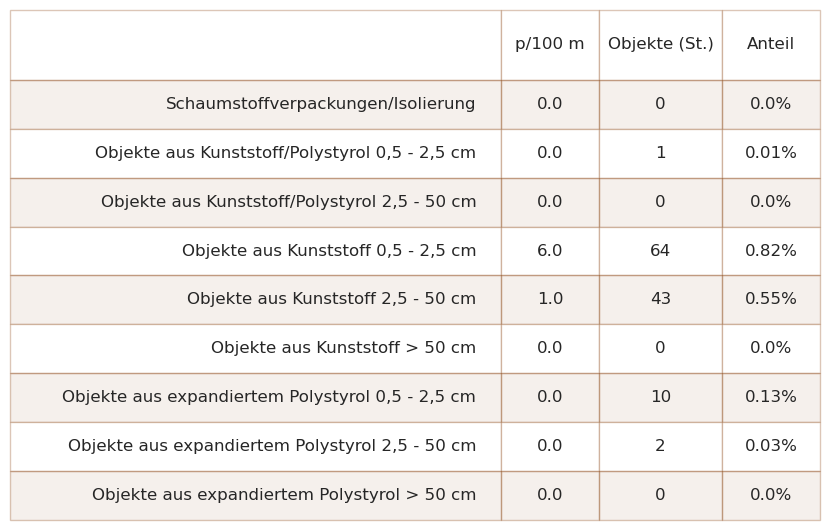

In [13]:
# collect the data before aggregating foams for all locations in the survye area
h=pd.read_csv("resources/checked_alpes_survey_data_be.csv")

# remove prefix
h["location"] = h["location"].map(lambda x: sut.get_rid_of_ix(x, prefix="clean-up-tour-"))

# remove prefixes from survey data
lAlps = h[h.river_bassin == this_feature["slug"]][["loc_date","code","location","river_bassin","groupname", "quantity", "pcs_m"]].copy()

# convert to reporting unit
lAlps[unit_label]= (lAlps.pcs_m*100).round(2)

# the fragmented plastics and foams
some_foams = ["G81", "G82", "G83", "G74"]
some_frag_plas = list(lAlps[lAlps.groupname == "plastic pieces"].code.unique())

# get just the foams and plastics and aggregate to code
conditions = ((lAlps.code.isin([*some_frag_plas, *some_foams]))&(~lAlps.location.isin(not_trail_samples)))
fd_frags_foams = lAlps[conditions].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code", as_index=False).agg(agg_pcs_median)

# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.code.map(lambda x: description_map.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{x}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]].copy()
data.rename(columns={"item": "Objekte", "quantity": "Objekte (St.)", "% of total":"Anteil"}, inplace=True)

fig, axs = plt.subplots(figsize=(len(data.columns)*2.1,len(data)*.6))
sut.hide_spines_ticks_grids(axs)

this_table = sut.make_a_table(axs, data.values,  colLabels=data.columns, colWidths=[.6, .12, .15, .12], bbox=[0, 0, 1, 1])
this_table.get_celld()[(0,0)].get_text().set_text(" ")
this_table.set_fontsize(12)

plt.tight_layout()
glue('alpes_survey_area_fragmented_plastics', fig, display=False)
plt.close()

```{glue:figure} alpes_survey_area_fragmented_plastics
---
name: 'alpes_survey_area_fragmented_plastics'
---
` `
```
{numref}`Abbildung %s: <alpes_survey_area_fragmented_plastics>` fragmentierte Schaumstoffe und Kunststoffe nach Grössengruppen. Median p/100 m, Anzahl Objekte, Prozent der Gesamtmenge.

### Landnutzungsprofil der Erhebungsorte

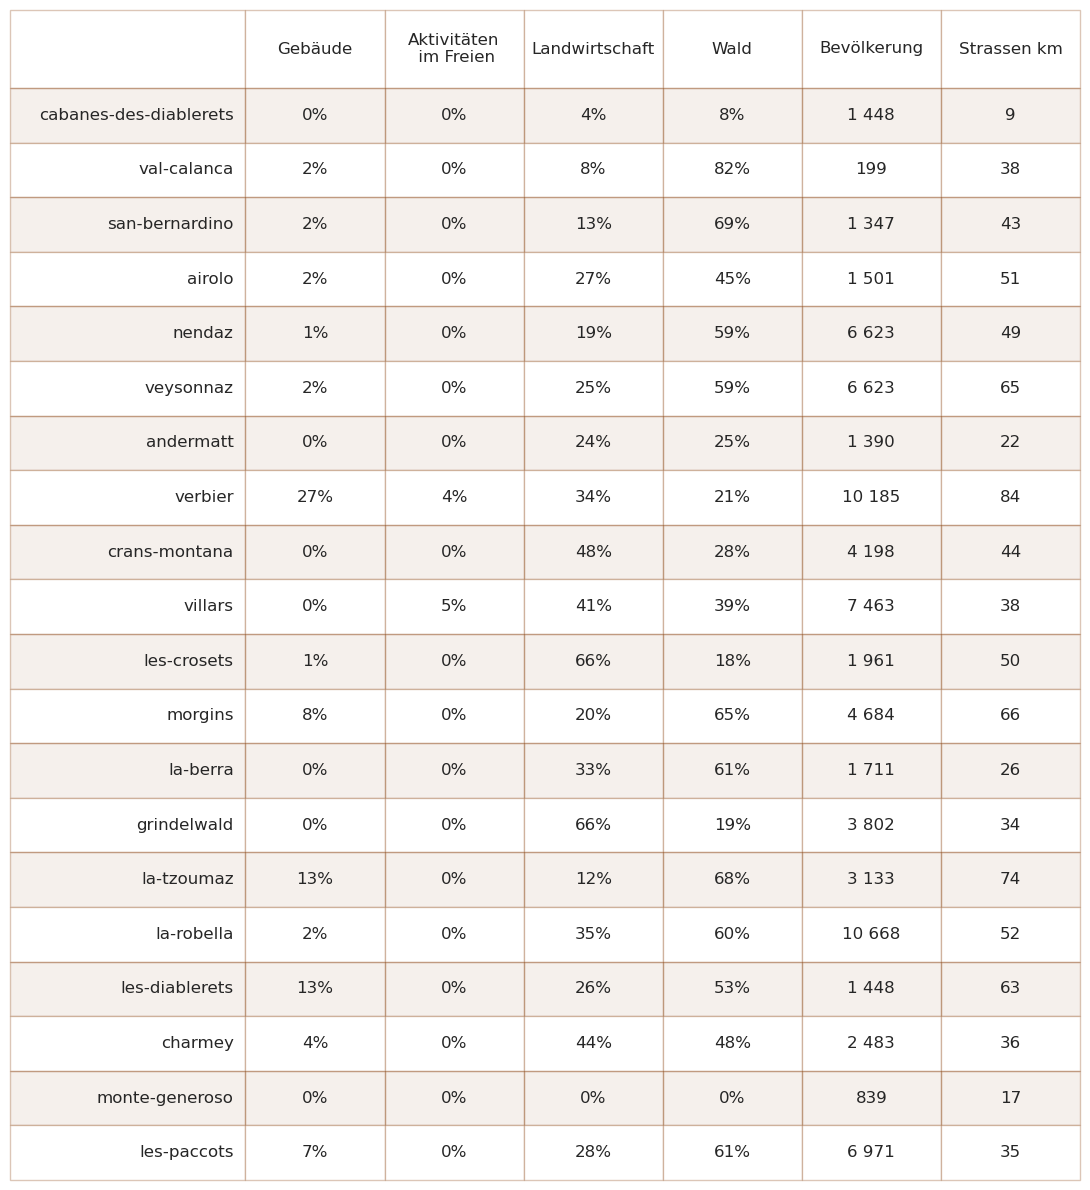

In [28]:
# get the land use profile of AV
# lu_prof = fd[["location","% buildings", "% recreation", "% agg", "% woods", "population", "streets"]].drop_duplicates()
lu_prof = fd[["location","% buildings", "% recreation", "% agg", "% woods", "population", "streets"]].drop_duplicates()
percents = ["% buildings", "% recreation", "% agg", "% woods"]
thousands = ["population"]

lu_prof["streets"] = (lu_prof["streets"]/1000).astype(int)

# format for printing
lu_prof[percents] = lu_prof[percents].applymap(lambda x: f"{int((x*100))}%")
lu_prof[thousands] = lu_prof[thousands].applymap(lambda x: featuredata.thousandsSeparator(int(x), "de"))
lu_prof.rename(columns=featuredata.luse_de, inplace=True)
lu_prof.rename(columns={"Aktivitäten im Freien":"Aktivitäten\n im Freien"}, inplace=True)

# put that to a table
data=lu_prof.copy()

fig, axs = plt.subplots(figsize=(11,len(data)*.6))
sut.hide_spines_ticks_grids(axs)

this_table = sut.make_a_table(axs, data.values,  colLabels=data.columns, colWidths=[.22, *[.13]*6], bbox=[0, 0, 1, 1])
this_table.get_celld()[(0,0)].get_text().set_text(" ")
this_table.set_fontsize(12)

plt.tight_layout()
glue('alpes_survey_area_luse_commune', fig, display=False)
plt.close()

```{glue:figure} alpes_survey_area_luse_commune
---
name: 'alpes_survey_area_luse_commune'
---
` `
```
{numref}`Abbildung %s: <alpes_survey_area_luse_commune>` Landnutzungsprofil der ErhebungsorteGesamtmenge. LWS = Landwirtschaft

### Alpen und Jura in Bezug auf die Landnutzung

Die Ergebnisse aus den Alpen und dem Jura werden mit den anderen Erhebungsergebnissen verglichen, die entweder % bis Wald oder % bis Landwirtschaft (LWS) innerhalb der gleichen Spanne wie AV liegen. Die Bereiche für Alpen und Jura sind:

* Landwirtschaft: 0 to 66\%
* Wald: 0 to 83\%
* Bevölkerung: 199 to 10,668

In [15]:
# define land use ranges based on the sample data
this_range = (fd[l_f[0]].min(), fd[l_f[0]].max())
this_range_w = (fd[l_f[1]].min(), fd[l_f[1]].max())
this_range_p = (fd[l_f[2]].min(), fd[l_f[2]].max())

# apply them to all the data
# one test for agg -- a dominant land use feature of the sample data
some_data = a_data[(a_data[l_f[0]] >= this_range[0])&(a_data[l_f[0]] <= this_range[1])].copy()

# one test for woods -- the dominant land use feature of the sample data
some_data_w = a_data[(a_data[l_f[1]] >= this_range_w[0])&(a_data[l_f[1]] <= this_range_w[1])].copy()

# one test for population -- 
some_data_p = a_data[(a_data[l_f[2]] >= this_range_p[0])&(a_data[l_f[2]] <= this_range_p[1])].copy()

# remove Alps valaisannes
some_data = some_data[~some_data.location.isin(fd.location.unique())].copy()
some_data_w = some_data_w[~some_data_w.location.isin(fd.location.unique())].copy()
some_data_p = some_data_p[~some_data_p.location.isin(fd.location.unique())].copy()

# the number of samples and locations that have similar land use profiles as AV:
# agg to loc_date for each criteria
# data for charting and comparing
data=some_data.groupby(["loc_date","location",l_f[0]], as_index=False)[unit_label].sum()
data_w =some_data_w.groupby(["loc_date","location", l_f[1]], as_index=False)[unit_label].sum()
data_p = some_data_p.groupby(["loc_date","location",l_f[1], "population"], as_index=False)[unit_label].sum()
regional = fd.groupby(["loc_date","location", *l_f], as_index=False)[unit_label].sum()

# locations that share the characteristics
commonsamps = set(data.loc_date.unique()) & set(data_w.loc_date.unique())& set(data_p.loc_date.unique())
commonlocs = set(data.location.unique()) & set(data_w.location.unique())&set(data_p.location.unique())

# print these out to get the comparison

# print("agg")
# print(this_range)
# print(len(data.location.unique()))
# print(data.loc_date.nunique())
# print("woods")
# print(this_range_w)
# print(len(data_w.location.unique()))
# print(data_w.loc_date.nunique())
# print("p")
# print(this_range_p)
# print(len(data_p.location.unique()))
# print(data_p.loc_date.nunique())
# print(len(commonsamps))
# print(commonlocs)

# make a categorical df for mapping
mat_agg = dfBeaches.loc[data.location.unique()]
mat_agg["match"] = "agg"
mat_w = dfBeaches.loc[data_w.location.unique()]
mat_w["match"] = "woods"
mat_p = dfBeaches.loc[data_p.location.unique()]
mat_p["match"]="pop"

# merge all that and export to .csv
landusemap = pd.concat([mat_agg, mat_w, mat_p], axis=0)
# landusemap.to_csv("output/Alps-valaisannes/lu_comparison.csv", index=False)

*__Oben links:__ Gesamtsumme der Erhebung in Bezug auf den %-Anteil an Agg, Bereich=(0%, 66%). __Oben rechts:__ Gesamtzahl der Erhebungen in Bezug auf den Waldanteil, Bereich=(0%, 65%). __Unten links:__ Gesamtzahl der Erhebungen in Bezug auf die Bevölkerung, Bereich=(199, 10.668)*

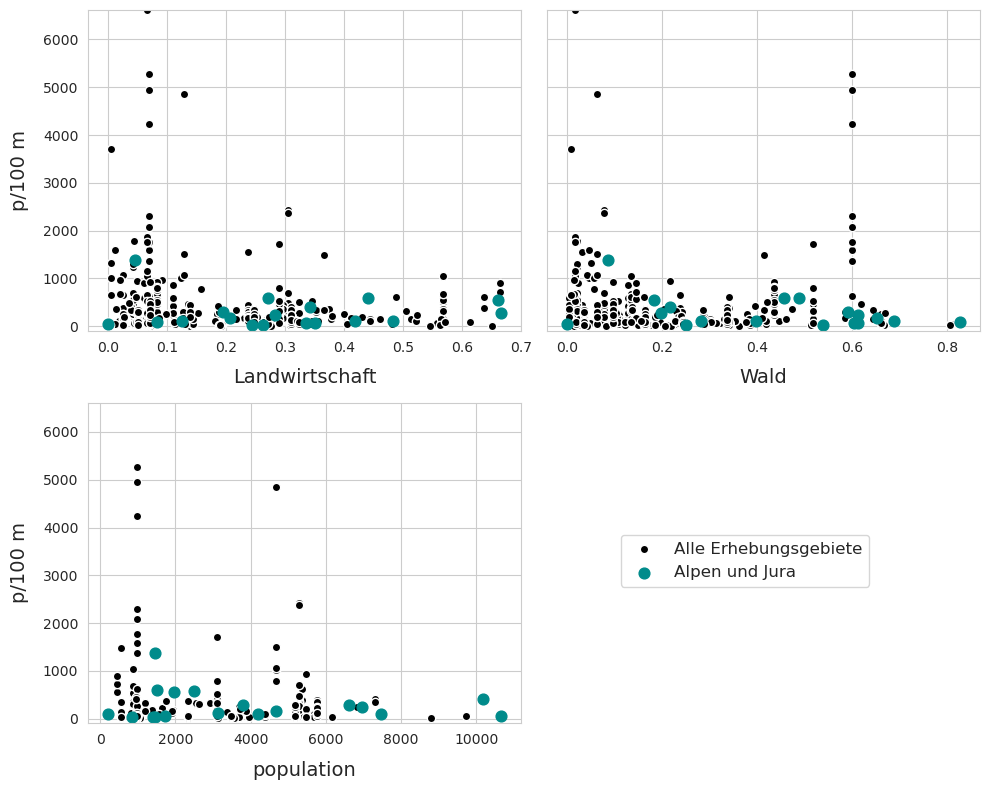

In [16]:
fig, axs = plt.subplots(2,2, figsize=(10,8), sharey=True)

axone=axs[0,0]
axtwo=axs[0,1]
axthree=axs[1,0]
axfour=axs[1,1]

# plot the samples from all the data that meet the x criteria
sns.scatterplot(data=data, x=l_f[0], y=unit_label, color="black", alpha=1, linewidth=1, label="All surveys", ax=axone, zorder=1)

# point estimates of the percentile ranking based off the edcf of all surveys
# place to store the rankings
rankings = {}

# plot the values for AV
for x in regional.location.unique():
    this_y = regional[regional.location == x][unit_label]
    this_x = regional[regional.location == x][l_f[0]]
    axone.scatter(this_x, this_y, color=bassin_pallette[this_feature["slug"]], s=60, zorder=2)

# handle extreme values
axone.set_ylim(0, max(data[unit_label].to_numpy()))

# set labels
axone.set_ylabel(unit_label, **ck.xlab_k14)
axone.set_xlabel(featuredata.luse_de[l_f[0]], **ck.xlab_k14)

# gather up legend handles
axone.get_legend().remove()

# start axtwo
# plot the samples from all the data that meet the x criteria
sns.scatterplot(data=data_w, x=l_f[1], y=unit_label, color="black", alpha=1, linewidth=1, label="All surveys", ax=axtwo, zorder=1)

# plot the values from AV
for x in regional.location.unique():
    this_y = regional[regional.location == x][unit_label]
    this_x = regional[regional.location == x][l_f[1]]
    rankings.update({x:(this_x, this_y)})
    axtwo.scatter(this_x, this_y, color=bassin_pallette[this_feature["slug"]], s=60, zorder=2)

# handle extreme values
axtwo.set_ylim(0, max(data[unit_label].to_numpy()))

# set labels
axtwo.set_ylabel(unit_label, **ck.xlab_k14)
axtwo.set_xlabel(featuredata.luse_de[l_f[1]], **ck.xlab_k14)
axtwo.get_legend().remove()

# start axthree
# plot the samples from all the data that meet the x criteria
sns.scatterplot(data=data_p, x=l_f[2], y=unit_label, color="black", alpha=1, linewidth=1, label=top, ax=axthree, zorder=1)

# plot the values from AV
for x in regional.location.unique():
    this_y = regional[regional.location == x][unit_label]
    this_x = regional[regional.location == x][l_f[2]]
    rankings.update({x:(this_x, this_y)})
    axthree.scatter(this_x, this_y, color=bassin_pallette[this_feature["slug"]], s=60, label=this_feature["name"], zorder=2)

# handle extreme values
axthree.set_ylim(-100, max(data[unit_label].to_numpy()))

# start axfour,# clear axfour
sut.hide_spines_ticks_grids(axfour)

# set labels
axthree.set_ylabel(unit_label, **ck.xlab_k14)
axthree.set_xlabel(l_f[2], **ck.xlab_k14)
handles, labels = axthree.get_legend_handles_labels()
axthree.get_legend().remove()

fig.legend(handles[:2], labels[:2], bbox_to_anchor=(.75,.25), loc="lower center",  fontsize=12)
plt.tight_layout()
glue('alpes_survey_area_compare_luse', fig, display=False)
plt.close()

{numref}`Abbildung %s: <alpes_survey_area_compare_luse>` __Oben links:__ Gesamtsumme der Erhebung in Bezug auf den prozentualen Anteil an landwirtschaftlich genutzter Fläche, Bereich = (0 %, 66 %). __Oben rechts:__ Gesamtzahl der Erhebungen in Bezug auf den Waldanteil, Bereich = (0 %, 65 %). __Unten links:__ Gesamtzahl der Erhebungen in Bezug auf die Bevölkerung, Bereich = (199, 10 668)

```{glue:figure} alpes_survey_area_compare_luse
---
name: 'alpes_survey_area_compare_luse'
---
` `
```


### Organisation und Durchführung

Summit foundation: Téo Gürsoy

Hammerdirt: Bettina Siegenthaler

### Die Erhebungsorte

In [17]:
# display the survey locations
pd.set_option("display.max_rows", None)

disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[t["locations"]][disp_columns]
new_names = {"slug":"Standort", "city":"Stadt"}
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns=new_names, inplace=True)
disp_beaches.set_index("Standort", inplace=True, drop=True)

disp_beaches

,latitude,longitude,Stadt
Standort,,,
cabanes-des-diablerets,46.338604,7.215525,Ormont-Dessus
val-calanca,46.330718,9.120103,Calanca
san-bernardino,46.445947,9.191344,Mesocco
airolo,46.514257,8.607884,Airolo
nendaz,46.162099,7.283486,Nendaz
veysonnaz,46.180334,7.366005,Nendaz
andermatt,46.618327,8.598803,Andermatt
verbier,46.103981,7.224760,Val de Bagnes
crans-montana,46.334214,7.479386,Lens


### Inventar der Objekte

In [18]:
pd.set_option("display.max_rows", None)
complete_inventory = fdx.code_summary.copy()
complete_inventory["quantity"] = complete_inventory["quantity"].map(lambda x: featuredata.thousandsSeparator(x, language))
complete_inventory["% of total"] = complete_inventory["% of total"].astype(int)
complete_inventory[unit_label] = complete_inventory[unit_label].astype(int)
complete_inventory.rename(columns=featuredata.inventory_table_de, inplace=True)
complete_inventory.sort_values(by="Objekte (St.)", ascending=False)

,Objekte,Objekte (St.),Anteil,p/100 m,Häufigkeitsrate,Material
code,,,,,,
G702,Pistenmarkierungspfosten (Holz),9,0,0,20,Holz
G100,Medizin; Behälter/Röhrchen/Verpackungen,9,0,0,40,Plastik
G31,"Schleckstengel, Stengel von Lutscher",9,0,0,25,Plastik
G200,"Getränke Glasflasche, Stücke",84,1,0,45,Glas
G74,Schaumstoffverpackungen/Isolierung,8,0,0,10,Plastik
G129,Schläuche und Gummiplatten,8,0,0,5,Gummi
G921,Keramikfliesen und Bruchstücke,7,0,0,10,Glas
G177,Verpackungen aus Aluminiumfolie,68,0,1,60,Metall
G124,Andere Kunststoff,60,0,0,5,Plastik
